## Analysing the experimental data of  [Brydges et al, Science 2019](https://doi.org/10.1126/science.aau4963)

In [1]:
using Revise
using RandomMeas
using ProgressMeter

In [2]:
## parameters 
N = 10 # System size
times = [0,1,2,3,4,5] # quench times in ms
ntimes = length(times)  # number of time points
ξ = siteinds("Qubit", N); # site indices of the shadows

# Parameters specifying the Renyi entropies of interest
k_max = 6 # maximal Renyi index (n-th Renyi entropy)
NA_max = 6; #maximal subsystem size. We always consider subsystems of the form [1,2,...,NA].

We now load the experimental randomized measurement data obtained in Brydges et al., Science 2018.

In [3]:
data = Vector{MeasurementData}(undef, ntimes)

for s in 1:ntimes
    data[s] = import_measurement_data("BrydgesScience2019data/measurement_data_10_T_" * string(times[s]) * ".npz",site_indices=ξ, add_value = 1)
end 

┌ Warning: The add_value parameter is 1 and added to all measurement results. The measurement results contain now only Set([2, 1]) .
└ @ RandomMeas /Users/aelben/Andreas_Arbeit/Projects/RandomMeas.jl/src/MeasurementData.jl:115
┌ Warning: The add_value parameter is 1 and added to all measurement results. The measurement results contain now only Set([2, 1]) .
└ @ RandomMeas /Users/aelben/Andreas_Arbeit/Projects/RandomMeas.jl/src/MeasurementData.jl:115
┌ Warning: The add_value parameter is 1 and added to all measurement results. The measurement results contain now only Set([2, 1]) .
└ @ RandomMeas /Users/aelben/Andreas_Arbeit/Projects/RandomMeas.jl/src/MeasurementData.jl:115
┌ Warning: The add_value parameter is 1 and added to all measurement results. The measurement results contain now only Set([2, 1]) .
└ @ RandomMeas /Users/aelben/Andreas_Arbeit/Projects/RandomMeas.jl/src/MeasurementData.jl:115
┌ Warning: The add_value parameter is 1 and added to all measurement results. The measuremen

We estimate the purity using the direct purity estimation formula presented Brydges et al., Science 2019 and using classical shadows Huang et al., Nat. Phys. 2020.

In [4]:
p_direct = zeros(Float64,ntimes,NA_max)
p_shadow = zeros(Float64,ntimes,NA_max)
@showprogress for s in 1:ntimes
    for NA in 1:NA_max
        p_direct[s,NA] = get_purity_direct(data[s],collect(1:NA))
        p_shadow[s,NA] = get_purity_dense_shadows(data[s],collect(1:NA))
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:50


We estimate higher order Renyi entropies (up to order n) using batch shadows (c.f. Rath et al., PRXQ 2023). To do this for various subsystems, we can reduce the measurement data to the subsystem of interest, construct shadows for that and estimate the trace moments.

In [5]:
p_bshadow = zeros(Float64,ntimes,NA_max,k_max-1)
S_bshadow = zeros(Float64,ntimes,NA_max,k_max-1)
@showprogress for s in 1:ntimes
    for NA in 1:NA_max
        reduced_data = reduce_to_subsystem(data[s],collect(1:NA)) # reduce the data to the subsystem [1,2,...,NA]
        dense_shadows = get_dense_shadows(reduced_data; number_of_ru_batches = k_max ) # get the dense batch shadows for that subsystem
        p_bshadow[s,NA,:] = get_trace_moments(dense_shadows,collect(2:k_max)) # get the tracemoment from the batch shadows
        for k in 2:k_max
            S_bshadow[s,NA,k-1]= log2(p_bshadow[s,NA,k-1])/(1-k)
        end
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Alternatively, we can construct the shadows for the largest subsystem first, and then trace out qubits to restrict to smaller subsystems. This is slightly faster.

In [6]:
p_bshadow = zeros(Float64,ntimes,NA_max,k_max-1)
S_bshadow = zeros(Float64,ntimes,NA_max,k_max-1)
@showprogress for s in 1:ntimes
    data_NA_max = reduce_to_subsystem(data[s],collect(1:NA_max)) # reduce the data to the maximal subsystem [1,2,...,NA_max]
    dense_shadows = get_dense_shadows(data_NA_max; number_of_ru_batches = k_max ) # get the dense batch shadows for that maximal subsystem
    for NA in NA_max:-1:1
        dense_shadows = partial_trace(dense_shadows,collect(1:NA)) # reduce the batch shadows to the subsystem [1,2,...,NA]
        p_bshadow[s,NA,:] = get_trace_moments(dense_shadows,collect(2:k_max)) # get the tracemoment from the batch shadows
    end
end


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08


Finally, we load quantum states generated by classical simulations (master equation evolution) of the experiment, including a decoherence model. We compute Renyi entropies.

In [7]:
using MAT

#TODO: Simplify this code

ρ = Vector{ITensor}()
p = zeros(Float64,ntimes,NA_max,k_max-1)
S = zeros(Float64,ntimes,NA_max,k_max-1)
SvN = zeros(Float64,ntimes,NA_max)
ITensors.disable_warn_order()

for s in 1:ntimes
    qstate = matread("BrydgesScience2019data/rho_10_XY_10_-1.00_0.00"*string(times[s])*"_1_1_1_flr_1.mat")["rho"]
    qstate = reshape(qstate,tuple((2*ones(Int,2*N))...))
    push!(ρ,ITensor(qstate,vcat(ξ',ξ)))
    for NA in 1:NA_max
        A = collect(1:NA)
        ρA = copy(ρ[s])
        for i in 1:N
            if !(i in A)
                ρA *= δ(ξ[i],ξ[i]') 
            end
        end
        for nt in 2:k_max
            p[s,NA,nt-1] = real(trace(power(ρA,nt),ξ[1:NA]))
            S[s,NA,nt-1]= log2(p[s,NA,nt-1])/(1-nt)
        end
    end
end

We plot the purity as a function of NA for the different times.

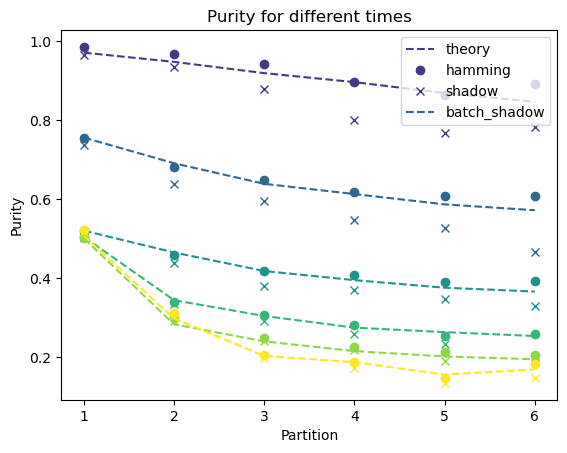

In [8]:
using PyPlot

clf()

cm = get_cmap(:viridis)
for s in 1:ntimes
    plot(1:NA_max,p[s,:,1],"--",color=cm(s/ntimes))
    plot(1:NA_max,p_direct[s,:],"o",color=cm(s/ntimes))
    plot(1:NA_max,p_shadow[s,:],"x",color=cm(s/ntimes))
end
#yscale("log")
xlabel("Partition")
ylabel("Purity")
legend(["theory","hamming","shadow","batch_shadow"])
title("Purity for different times")

gcf()

We plot the higher order Renyi entropies as a function of Renyi index n for a fixed subystem size and various times.

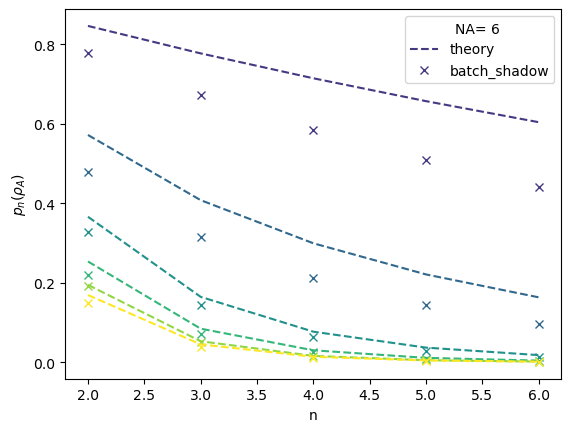

In [68]:
using PyPlot

clf()
cm = get_cmap(:viridis)
NA = 6
for s in 1:1
    plot(2:k_max,p[s,NA,:],"--",color=cm(s/ntimes),label="theory")
    plot(2:k_max,trace_moment_bshadow[s,NA,:],"x",color=cm(s/ntimes),label="batch_shadow")
end
for s in 2:ntimes
    plot(2:k_max,p[s,NA,:],"--",color=cm(s/ntimes))
    plot(2:k_max,trace_moment_bshadow[s,NA,:],"x",color=cm(s/ntimes))
end
xlabel("n")
ylabel(L"p_n(\rho_A)")
legend(title = "NA= $NA ")

gcf()

## Simulation of the experiment

In the following, we provide methods to simulate the Brydges experiment by loading the quantum states obtained from the Master equation simulation and performing randomized measurements on them.

In [11]:
using MAT
ITensors.disable_warn_order()

# Parameters
NU, NM = 100, 150

# times
times = [1,2] # quench times in ms

# Directory to save exported files
export_dir = "MeasurementDataExports/"  # Directory to save exported files
isdir(export_dir) || mkpath(export_dir) # Ensure the export directory exists

# Samples
samples = 5 # Number of times, we simulate the Brydges experiment with the same parameters 

@showprogress  for t in times
    # Load and process the quantum state
    qstate = matread("BrydgesScience2019data/rho_10_XY_10_-1.00_0.00"*string(t)*"_1_1_1_flr_1.mat")["rho"]
    qstate = reshape(qstate, tuple((2 * ones(Int, 2 * N))...))
    rho = ITensor(qstate, vcat(ξ', ξ))
    rho = MPO(rho, ξ, cutoff=1e-10)

    for sample in 1:samples
        # Generate measurement settings and simulate results
        measurement_settings = RandomMeas.LocalUnitaryMeasurementSettings(N, NU, site_indices=ξ)
        measurement_data = simulate_local_measurements(rho, NM; mode="dense", measurement_settings=measurement_settings)

        # Construct a meaningful filename
        filename = joinpath(export_dir, "simulated_measurement_data_t_$(t)_sample_$(sample)_NU_$(NU)_NM_$(NM).npz")

        # Export the data
        export_measurement_data(measurement_data, filename)
        println("Exported: $filename")

    end
end

Exported: MeasurementDataExports/simulated_measurement_data_t_1_sample_1_NU_100_NM_150.npz
Exported: MeasurementDataExports/simulated_measurement_data_t_1_sample_2_NU_100_NM_150.npz
Exported: MeasurementDataExports/simulated_measurement_data_t_1_sample_3_NU_100_NM_150.npz
Exported: MeasurementDataExports/simulated_measurement_data_t_1_sample_4_NU_100_NM_150.npz
Exported: MeasurementDataExports/simulated_measurement_data_t_1_sample_5_NU_100_NM_150.npz
Exported: MeasurementDataExports/simulated_measurement_data_t_2_sample_1_NU_100_NM_150.npz
Exported: MeasurementDataExports/simulated_measurement_data_t_2_sample_2_NU_100_NM_150.npz
Exported: MeasurementDataExports/simulated_measurement_data_t_2_sample_3_NU_100_NM_150.npz
Exported: MeasurementDataExports/simulated_measurement_data_t_2_sample_4_NU_100_NM_150.npz
Exported: MeasurementDataExports/simulated_measurement_data_t_2_sample_5_NU_100_NM_150.npz


We load the data and estimate trace moments.

In [72]:
using MAT
ITensors.disable_warn_order()

# Parameters
NU, NM = 100, 150

# times
times = [1,2] # quench times in ms

# Directory to save exported files
import_dir = "MeasurementDataExports/"  # Directory to save exported files

# Samples
samples = 5 # Number of times, we simulate the Brydges experiment with the same parameters 

k_max = 6
NA_max = 6

p_bshadow = zeros(Float64,samples,length(times),NA_max,k_max-1)
S_bshadow = zeros(Float64,samples,length(times),NA_max,k_max-1)

for (s,t) in enumerate(times)

    for sample in 1:samples

        filename = joinpath(export_dir, "simulated_measurement_data_t_$(t)_sample_$(sample)_NU_$(NU)_NM_$(NM).npz")

        loaded_data = import_measurement_data(filename, site_indices=ξ)

        data_NA_max = RandomMeas.reduce_to_subsystem(loaded_data,collect(1:NA_max)) # reduce the data to the maximal subsystem [1,2,...,NA_max]
        dense_shadows = RandomMeas.get_dense_shadows(data_NA_max; number_of_ru_batches = k_max ) # get the dense batch shadows for that maximal subsystem

        for NA in NA_max:-1:1
            dense_shadows = RandomMeas.partial_trace(dense_shadows,collect(1:NA)) # reduce the batch shadows to the subsystem [1,2,...,NA]
            p_bshadow[sample,s,NA,:] = RandomMeas.get_trace_moments(dense_shadows,collect(2:k_max)) # get the tracemoment from the batch shadows
            for k in 2:k_max
                S_bshadow[sample,s,NA,k-1]= log2(p_bshadow[sample,s,NA,k-1])/(1-k)
            end
        end
    end
end

keys(data) = ["local_unitaries", "measurement_results"]
keys(data) = ["local_unitaries", "measurement_results"]
keys(data) = ["local_unitaries", "measurement_results"]
keys(data) = ["local_unitaries", "measurement_results"]
keys(data) = ["local_unitaries", "measurement_results"]
keys(data) = ["local_unitaries", "measurement_results"]
keys(data) = ["local_unitaries", "measurement_results"]
keys(data) = ["local_unitaries", "measurement_results"]
keys(data) = ["local_unitaries", "measurement_results"]
keys(data) = ["local_unitaries", "measurement_results"]
